# Exploring Salt Lake City's Real Estate Market
## A statistical approach
#### Katherine Chandler, K2 Applied Statistics

In [1]:
import os.path
import pandas as pd
import urllib.parse
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import csv
import statsmodels.api as sm
import statsmodels.graphics as smg
from statsmodels.sandbox.regression.predstd import wls_prediction_std
import scipy.stats as stats
import itertools
import warnings
warnings.filterwarnings('ignore')

/Users/jeff/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Background
I love smaller homes, and in the previous project I explored the 'bigger is not better' movement with an initial exploratory analysis of active and historic real estate data in the Salt Lake City metro area. I found that small homes in the urban center are more valuable per square foot than large suburban homes and maintain their value more robustly during times of market contraction. In this project, I used statistical inference and linear regression to validate these initial findings, and explore the ways in which various factors impact home pricing.

## Questions for Exploration

* Are the regional differences in price and size statistically significant?
* Are comparable size listings in different regions significantly different in listing price?
* Can we model home pricing based on size and geography characteristics?

## Data Sources

#### Active Listing Data

I generated comprehensive data on active listings for 27 unique Salt Lake City ZIP codes using the modified [```scrapehero zillow.py```](https://gist.github.com/scrapehero/5f51f344d68cf2c022eb2d23a2f1cf95 "scrapehero"). The modified scraping script (```zillow.py```), the script to call the scraping script (```zillow_scraper_calls.py```), ZIP code list, and resulting csv listing file can be found in the ```'zillow_scraper'``` folder of this repository.

The scraped data set includes 841 unique listings containing information about listing type ('title'), address, city, state, ZIP code ('postal_code'), listed sale price (in USD), size (in square feet), bedroom/bathroom count, and the active listing URL.

#### Historical Housing Price Data

I used the 'Home Values' data sets provided in the [Zillow Research Data sets](https://www.zillow.com/research/data/ "Zillow Research Data") (downloaded data sets in the ```'zillow_research_home_values'``` folder of this repository). The 'Home Values' data sets are smoothed, seasonally adjusted aggregates of estimated real estate value cut by zip code and number of bedrooms. Estimated real estate value is measured as the Zillow Home Value Index (ZHVI), a home price index (in USD) computed based on proprietary statistical and machine learning models ([ZHVI methodology here](https://www.zillow.com/research/zhvi-methodology-6032/ "ZHVI methodology")). The ZHVI time series contains monthly data for the period from April 1996 to February 2018.

## Cleaning the Data

#### Active Listing Data

The full cleaning code and logic for the active listing data can be found in the 'Zillow_SLC_Current_Active_Listings' notebook in the 'analysis_notebooks' of this repository.

#### Historical Housing Price Data

The full pre-processing for the active listing data can be found in the 'Zillow_SLC_Historical_Data' notebook in the 'analysis_notebooks' of this repository.

## Exploring the Data

The cleaned and processed active listing data was saved to a csv file from the 'Zillow_SLC_Current_Active_Listings' processing notebook and imported for the analyses below. 

In [2]:
active_listings = pd.read_csv('~/Desktop/K2_DataScience/K2_Project2/Zillow_Analysis_Salt_Lake_City/zillow_analysis_notebooks/zillow_slc_current_listings_processed.csv',
                             index_col=0)

historical_listings = pd.read_csv('~/Desktop/K2_DataScience/K2_Project2/Zillow_Analysis_Salt_Lake_City/zillow_analysis_notebooks/zillow_slc_historic_prices_processed.csv',
                             index_col=0).reset_index(drop=True)

In [3]:
# only keep data that I want to do stats and modeling on
active_listings_filtered = active_listings.drop(labels=['title', 'address', 'city', 'state', 'facts and features', 'url'], axis =1)

# create data frame with NaN removed
active_listings_filtered.dropna(inplace=True)

In [4]:
# this display option will make it easier to see price data
pd.options.display.float_format = '{:20,.2f}'.format

In [5]:
# change postal code type to string since it is a categorical feature
format_post_codes = active_listings_filtered['postal_code']
format_post_codes = format_post_codes.astype('str')
active_listings_filtered.drop(labels='postal_code', axis=1)
active_listings_filtered['postal_code'] = format_post_codes

In [21]:
# dropped size_type since it won't be used in modeling
active_listings_filtered.drop(['size_type'], axis=1, inplace=True)

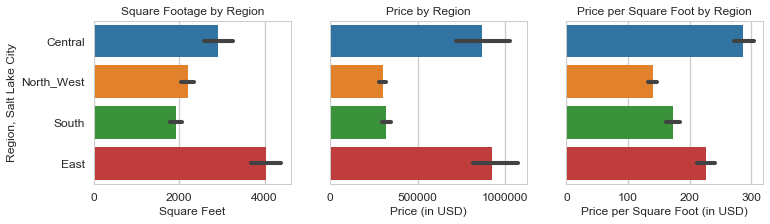

In [6]:
#plotting square footage by region
fig = plt.figure(figsize=[12,3])
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.1)

fig.add_subplot(131)   #left
ax = sns.barplot(y="region", x="sqft", data=active_listings_filtered)
plt.xlabel('Square Feet', fontsize=12)
plt.ylabel('Region, Salt Lake City', x=2, fontsize=12)
plt.title('Square Footage by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12)

#plotting price by region
fig.add_subplot(132)   #middle
ax = sns.barplot(y="region", x="price", data=active_listings_filtered)
plt.xlabel('Price (in USD)', fontsize=12)
ax.get_yaxis().set_visible(False)
plt.title('Price by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)

#plotting price per square foot by region
fig.add_subplot(133)   #right
ax = sns.barplot(y="region", x="price_per_sqft", data=active_listings_filtered)
plt.xlabel('Price per Square Foot (in USD)', fontsize=12)
ax.get_yaxis().set_visible(False)
plt.title('Price per Square Foot by Region', y=1, fontsize=12)
plt.setp(ax.get_xticklabels(), fontsize=12)

plt.show()

The above plots summarize intial findings of the data exploration phase. At a high level, the data indicates differences in property types between the four different geographic areas of Salt Lake City: Central, North-West, South, and East. Homes in the Central urban area and East suburbs are larger and more expensive (absolute value and price per square foot) than homes in the North-West and South suburbs. So, are these differences significant?

#### Question 1. Are the regional differences in price and size statistically significant?

To address this question I calculated and plotted pairwise Tukey's Honest Significant Difference test (Tukey's HSD) tests given a set of geographic and numeric parameters. These tests establish a confidence interval to compare the means of all pairs within a given group and establish whether two groups are statistically different (i.e. 'reject' the null hypothesis that the groups are not different). Functions to perform these tests were imported in a module titled `zillowlib`.

In [38]:
import math
from statsmodels.stats.multicomp import pairwise_tukeyhsd
#import functions built for this analysis
from analysis.zillowlib import *   

In [39]:
# run summarize_tukey_significant on listings cut by geography and size type and compare price, size, and 
# price per sqft this function only returns relationships with statistically significant differences

geography_cut_list = ['postal_code', 'neighborhood', 'region']
metric_list = ['price', 'sqft', 'price_per_sqft']

summarize_tukey_significant(active_listings_filtered, geography_cut_list, metric_list)


Tukey's HSD test for postal_code and price
84103  84106  True  
84103  84107  True  
84103  84111  True  
84103  84115  True  
84103  84118  True  
84103  84119  True  
84103  84120  True  
84103  84123  True  
84103  84128  True  
84103  84129  True  
84106  84121  True  
84107  84121  True  
84108  84119  True  
84115  84121  True  
84117  84119  True  
84118  84121  True  
84119  84121  True  
84120  84121  True  
84121  84123  True  
84121  84128  True  
84121  84129  True  

Tukey's HSD test for postal_code and sqft
84101  84103  True  
84101  84108  True  
84101  84117  True  
84101  84121  True  
84101  84124  True  
84102  84121  True  
84103  84106  True  
84103  84111  True  
84103  84115  True  
84103  84118  True  
84103  84119  True  
84103  84123  True  
84104  84121  True  
84105  84121  True  
84106  84108  True  
84106  84117  True  
84106  84121  True  
84107  84121  True  
84108  84111  True  
84108  84119  True  
84109  84121  True  
84111  84117  True  
84111  841

These pairwise Tukey tests show many relationships with significant differences, but the zip code and neighborhood level data is too granular to make interesting generalizations about trends. Below I plotted the confidence intervals generated by the Tukey pairwise tests to visualize these relationships.

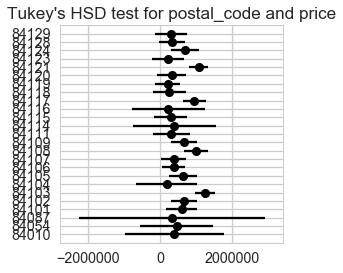

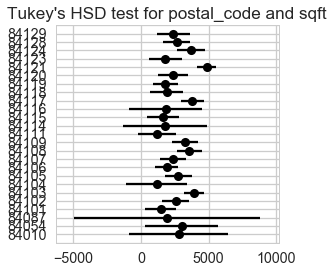

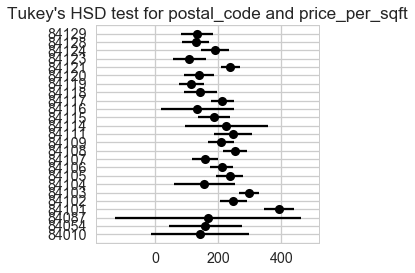

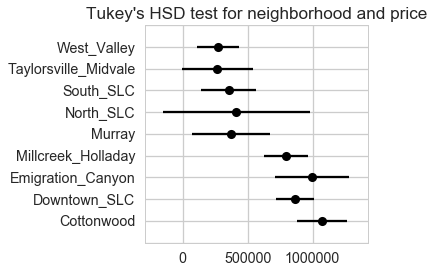

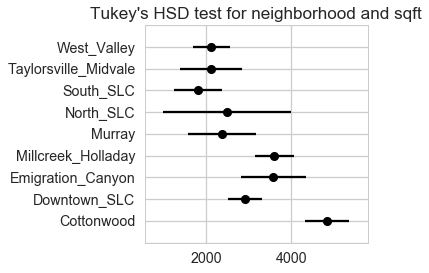

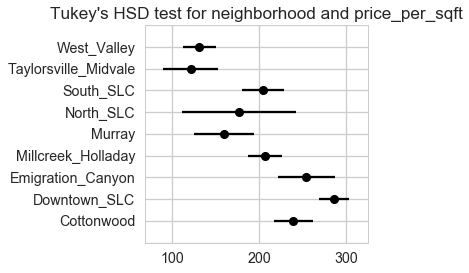

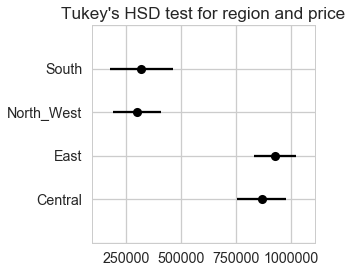

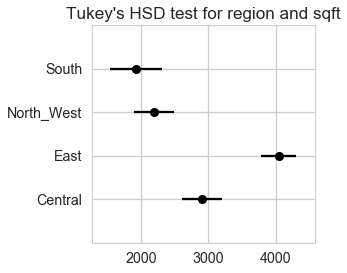

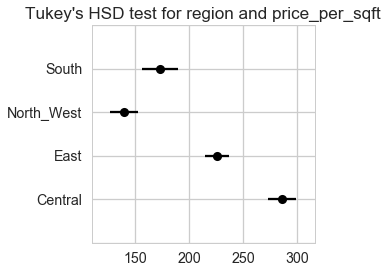

In [9]:
# run plot_tukey on listings cut by geography and size type and compare price, size, and price_per_sqft
# this function plots the confidence interval for which the mean metric falls for the given geographic cut
# overlapping confidence intervals suggests that mean values are not significantly different

plot_tukey(active_listings_filtered, geography_cut_list, metric_list)

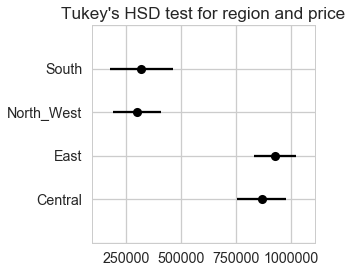

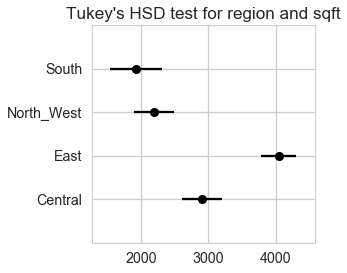

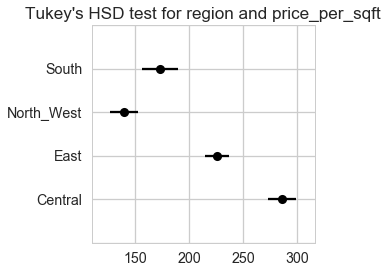

In [41]:
plot_tukey(active_listings_filtered, ['region'], metric_list)

This visualization shows that the geographic cut 'region' is granular enough to reveal distinct differences in size and price while being broad enough to provide meaningful generalizations in the data. To gain a specific metric of the significance of these relationships, I calculated specific p-values (using a pairwise two tailed t-test) for these price/size metrics using the region geographic cut. 

In [10]:
# summarize significant differences for homes by region using p-val
metric_list = ['price', 'sqft', 'price_per_sqft']

for metric in metric_list:
    print(metric)
    calc_pval(active_listings_filtered, 'region', metric)
    print('\n')

price
p-val = 7.39280781124e-12 for Central, North_West
p-val = 3.3601817749e-11 for Central, South
p-val = 0.555512412442 for Central, East
p-val = 0.253306097696 for North_West, South
p-val = 2.52769585027e-17 for North_West, East
p-val = 2.04377101338e-16 for South, East


sqft
p-val = 0.00021494385414 for Central, North_West
p-val = 3.883383905e-07 for Central, South
p-val = 1.51183095753e-05 for Central, East
p-val = 0.0116710038856 for North_West, South
p-val = 2.75120514743e-17 for North_West, East
p-val = 1.00868743422e-21 for South, East


price_per_sqft
p-val = 1.05675342758e-41 for Central, North_West
p-val = 1.19140797275e-24 for Central, South
p-val = 1.16604732815e-07 for Central, East
p-val = 2.40428699874e-06 for North_West, South
p-val = 1.22373310639e-21 for North_West, East
p-val = 8.21976428772e-08 for South, East




This summary confirms that Central and East Salt Lake City listings are priced at significantly higher values than homes in the North-West or South parts of the city. All four regions are significantly different from the others in terms of size and price per square foot, confirming that these regions are distinct. So, to answer Question 1, **yes, the price and size distinctions are significant. Central and East Salt Lake have distinctly different prices than South and North-West Salt Lake, all regions have distinctly different sizes, and all regions have distinctly different price_per_sqft values.**

#### Question 2: Are comparable size listings in different regions significantly different in listing price?


I answered this question using a function that pairs comparable listings (by bedroom number) for each combination of regions and performs a two-tailed t-test to test for statistical differences. This test shows while many comps between East/Central and North-West/South are similar, there are lots of significant differences in the pricing of comparable homes between different regions. The most significant price difference in comparable listings was for 3-bedroom homes listed in the North-West region (median price \$249,900) and the East region (median price \$445,000.00).

In [11]:
# performing a t-test for comparable active listings based on region and price
calc_pval_comps(active_listings_filtered, 'region', 'price')

p-val = 0.0210204166731 for 1 bedrooms in Central, North_West
p-val = 1.90580312965e-07 for 2 bedrooms in Central, North_West
p-val = 1.72823913399e-06 for 3 bedrooms in Central, North_West
p-val = 0.0023984481483 for 4 bedrooms in Central, North_West
p-val = 0.000441076319802 for 5 bedrooms in Central, North_West
1 bedrooms in Central, South are not significantly different
p-val = 2.8053407e-08 for 2 bedrooms in Central, South
p-val = 4.191435187e-05 for 3 bedrooms in Central, South
p-val = 0.00363100451781 for 4 bedrooms in Central, South
p-val = 0.000370185690482 for 5 bedrooms in Central, South
1 bedrooms in Central, East are not significantly different
2 bedrooms in Central, East are not significantly different
3 bedrooms in Central, East are not significantly different
4 bedrooms in Central, East are not significantly different
5 bedrooms in Central, East are not significantly different
1 bedrooms in North_West, South are not significantly different
2 bedrooms in North_West, Sout

This data provides a definitive **yes, many types of comparable listings in different regions are listed at significantly different prices.** 

#### Question 3: Can we model home pricing based on size and geography characteristics?

From the statistical analyses above we can infer that there is a relationship between listing price, home size, and home region. The correlation heatmaps below illustrate these relationships graphically. As expected, there is a positive relationship between price and size. There is also a positive relationship between price and being in the East of Central regions, and a a negative relationship between price and being in North-West region. 

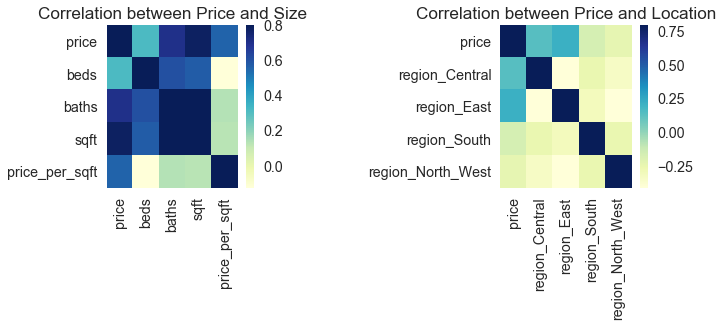

In [12]:
# look at correlations between price, size, and location

#calculate price:size correlation
size_corr = active_listings_filtered.corr()

#make dummies of region and calculate price:region correlation
region_corr = (pd.get_dummies(active_listings_filtered, columns=['region'])[['price', 'region_Central', 
                                 'region_East', 'region_South', 'region_North_West']]).corr()

fig= plt.figure(figsize=[10,3])

fig.add_subplot(131)
sns.heatmap(size_corr, vmax=0.8, cmap="YlGnBu")
plt.title('Correlation between Price and Size')

fig.add_subplot(133)
sns.heatmap(region_corr, vmax=0.8, cmap="YlGnBu")
plt.title('Correlation between Price and Location')

plt.show()

Can we use these relationships to build a linear regression model for the home listing price? I began by making a simple model based only on size, the number of bedrooms, and the number of bathrooms. I plotted the coefficents of each variable in the model (as a measure of the variable's impact) and assessed the quality by plotting several diagnostic plots for the model.

In [13]:
# create price model containing only size and features 

price_simple_results = sm.OLS.from_formula('price ~ beds + baths + sqft', active_listings_filtered).fit()
price_simple_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     442.7
Date:                Wed, 16 May 2018   Prob (F-statistic):          1.27e-165
Time:                        13:37:30   Log-Likelihood:                -11036.
No. Observations:                 756   AIC:                         2.208e+04
Df Residuals:                     752   BIC:                         2.210e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.874e+04   5.83e+04      1.352      0.177   -3.56e+04    1.93e+05
beds        -1.35e+05   1.74e+04     -7.759      0.000   -1.69e+05   -1.01e+05
baths       7.702e+04   2.77e+04      2.783      0.006    2.27e+04    1.31e+05
sqft         287.2264     17.748     16.184      0.000     252.385     322.068
==============================================================================
Omnibus:                      856.437   Durbin-Watson:                   1.820
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           168403.325
Skew:                           5.048   Prob(JB):                         0.00
Kurtosis:                      75.417   Cond. No.                     1.19e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.19e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [14]:
# calculate error bars from confidence limits
err_bar = price_simple_results.params - price_simple_results.conf_int()[0]

# create df with coefficents and error values; here I only wanted 'size' parameters so I sliced
coef_df = pd.DataFrame({'coef': price_simple_results.params.values[1:],
                        'err': err_bar.values[1:],
                        'varname': err_bar.index.values[1:]
                       })

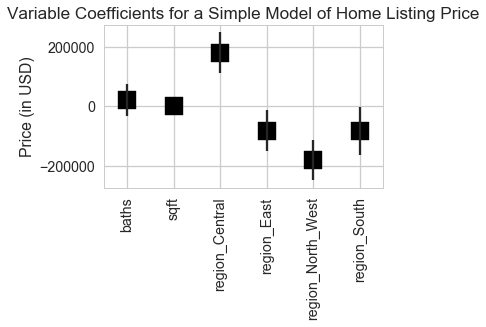

In [36]:
# plot coefficient with error bar for each size type

fig, ax = plt.subplots(figsize=(5,3))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=None)
ax.set_ylabel('Price (in USD)', x=8)
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=300, 
           y=coef_df['coef'], color='black')
plt.title('Variable Coefficients for a Simple Model of Home Listing Price')
plt.show()

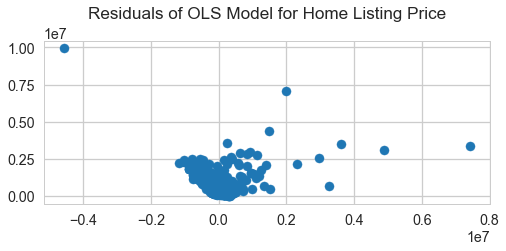

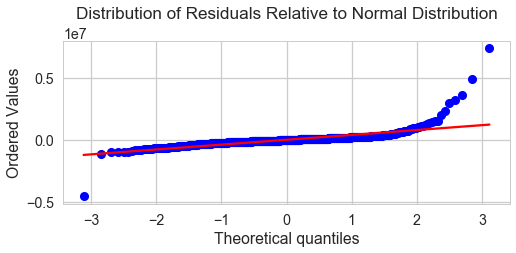

In [16]:
# calculate model residuals

import scipy as sp

pred_val = price_simple_results.fittedvalues.copy()
true_val = active_listings_filtered['price'].values.copy()
residual = true_val - pred_val

# regression diagnostic plots; plotting model residuals
fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(residual, pred_val)
plt.title('Residuals of OLS Model for Home Listing Price', y=1.1)
plt.show()


# regression diagnostic plots; plotting probability of residual data against the theoretical quantiles for 
# normal distribution; some deviations from normality but somewhat okay
fig, ax = plt.subplots(figsize=(8,3))
sp.stats.probplot(residual, plot=ax, fit=True)
plt.title('Distribution of Residuals Relative to Normal Distribution', y=1.1)
plt.show()

Simply modeling price by bedroom number, bathroom number, and size provides a reasonably good fit. Diagnostic plots for the model show outliers and a non-normal distribution, but this isn't surprising given the range in variables like finish quality, lot size, and age of home. All three variables (beds, baths, sqft) have significant p-values, and the model's $R^{2}$ is 0.638. Since my exploratory work highlighted the impact of geographic region on price, I wanted to generate a more complex model for price by creating dummy variables for the geographic features (zip code, neighborhood, and region).

The full analysis for each of these three geographic features is in the Zillow_SLC_Statistical_Tests notebook in this repository. To summarize, I built a set of functions (in `linearreglib.py`) to 1) create dummy variables for the given geographic variable, 2) build a string 'formula' for input to the `stats model's OLS` function, 3) generate a model using `OLS`, and 4) save several model quality measures to a dictionary. There are additional functions to generate all possible combinations of features to input into the model generator function and a function to summarize multiple models into a pd data frame. Used together, these latter two functions are essentially a simple version of the `sci-kit learn gridsearch` package, and I used them to select the best feature set for linear regression with my data.

I created models for all possible combinations of 2 or more features (plus the region dummy variables), and assessed model quality based on a combination of $R^{2}$ and the ratio of variables used in the model with significant p-values. The best model for listing price using 'region' as a dummy variable had an $R^{2}$ of 0.633 and 7 variables (6 had p-values greater than 0.05). The best model for listing price using 'neighborhood' as a dummy variable had an $R^{2}$ of 0.64 and 15 variables (only 9 had p-values greater than 0.05). The best model for listing price using 'postal_code' as a dummy variable had an $R^{2}$ of 0.65 and 31 variables (only 10 had p-values greater than 0.05).

Although the region dummy model had a slightly lower $R^{2}$, all of the included variables had significant p-values. The 'neighborhood' and 'postal_code' variables have more granularity than 'region', and these models may over fit to the data to non-relevant features. For these reasons, I selected the 'region dummy model' for further exploration. Below is the model fitting process for 'price' using 'region' as a dummy variable. Selecting the *best* model is somewhat subjective since models present a tradeoff of quality metrics, but I selected a model with a reasonably good $R^{2}$ and a high number of significant variables.

In [17]:
#import the library of functions for feature selection and model fitting
from analysis.linearreglib import * 

In [22]:
# calling the functions to model price and price_per_sqft using 'region' as the dummy

#define dependant variables
dependant_variables = ['price', 'price_per_sqft']
dummy_var = 'region'

#make combination list of features
feature_combinations_list = generate_feature_combinations_dummy_added(active_listings_filtered, dummy_var, dependant_variables)


# calling the summarize function on models of price and size for a range of features
price_region_summary = sumarize_multi_OLS_models(active_listings_filtered, dummy_var, dependant_variables, feature_combinations_list)

In [26]:
price_region_summary.sort_values(by='ratio_vars_significant', ascending=False).head(n=10)

,formula,r_squared,num_sig_variables,total_num_variables,ratio_vars_significant
"model_60, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + baths + region_Central...,0.28,7,7,1.00
"model_70, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + baths + region_Central...,0.28,7,7,1.00
"model_90, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + baths + region_Central...,0.28,7,7,1.00
"model_102, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + baths + sqft + region_...,0.28,7,8,0.88
"model_82, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + baths + sqft + region_...,0.28,7,8,0.88
"model_5, dep=price, dummy=region",price ~ beds + baths + region_Central + region...,0.53,6,7,0.86
"model_15, dep=price, dummy=region",price ~ beds + baths + region_Central + region...,0.53,6,7,0.86
"model_71, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + sqft + region_Central ...,0.28,6,7,0.86
"model_61, dep=price_per_sqft, dummy=region",price_per_sqft ~ beds + sqft + region_Central ...,0.28,6,7,0.86
"model_8, dep=price, dummy=region",price ~ baths + sqft + region_Central + region...,0.63,6,7,0.86


In [42]:
price_region_summary.loc['model_8, dep=price, dummy=region']['formula']


'price ~ baths + sqft + region_Central + region_East + region_North_West + region_South'

In [32]:
# create price model from 'best' model using region as a dummy variable

formula_best = price_region_summary.loc['model_8, dep=price, dummy=region']['formula']
price_region_best = sm.OLS.from_formula(formula_best, create_dummies(active_listings_filtered, 'region')).fit()
price_region_best.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.630
Method:                 Least Squares   F-statistic:                     258.5
Date:                Wed, 16 May 2018   Prob (F-statistic):          1.98e-160
Time:                        14:02:47   Log-Likelihood:                -11042.
No. Observations:                 756   AIC:                         2.210e+04
Df Residuals:                     750   BIC:                         2.212e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept         -1.658e+05   3.59e+04     -4.614      0.000   -2.36e+05   -9.53e+04
baths              2.058e+04   2.71e+04      0.760      0.448   -3.26e+04    7.38e+04
sqft                272.1343     17.943     15.166      0.000     236.909     307.359
region_Central     1.801e+05   3.54e+04      5.087      0.000    1.11e+05     2.5e+05
region_East       -8.222e+04   3.54e+04     -2.321      0.021   -1.52e+05   -1.27e+04
region_North_West -1.807e+05   3.47e+04     -5.208      0.000   -2.49e+05   -1.13e+05
region_South      -8.301e+04   4.16e+04     -1.995      0.046   -1.65e+05   -1331.527
==============================================================================
Omnibus:                      942.444   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           186881.458
Skew:                           6.057   Prob(JB):                         0.00
Kurtosis:                      79.066   Cond. No.                     2.90e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.31e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

The only significant variables in this 'best' model are the four region dummies and size. This highlights the fact that the original simple model using only size features was a reasonabley good approximator for price. As with the original model, I explored the variable coefficients and regression diagnostic plots.

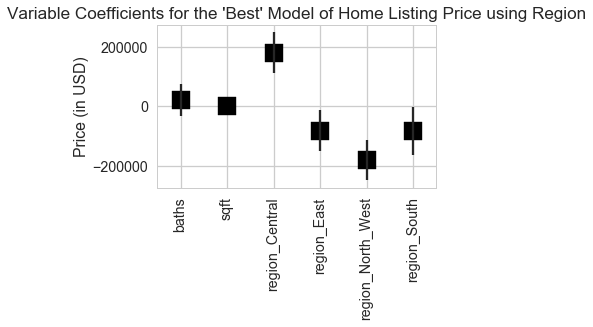

In [35]:
# calculate error bars from confidence limits
err_bar = price_region_best.params - price_region_best.conf_int()[0]

# create df with coefficents and error values; here I only wanted 'size' parameters so I sliced
coef_df = pd.DataFrame({'coef': price_region_best.params.values[1:],
                        'err': err_bar.values[1:],
                        'varname': err_bar.index.values[1:]
                       })

# plot coefficient with error bar for each size type

fig, ax = plt.subplots(figsize=(5,3))
coef_df.plot(x='varname', y='coef', kind='bar', 
             ax=ax, color='none', 
             yerr='err', legend=None)
ax.set_ylabel('Price (in USD)', x=8)
ax.set_xlabel('')
ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
           marker='s', s=300, 
           y=coef_df['coef'], color='black')
plt.title('Variable Coefficients for the \'Best\' Model of Home Listing Price using Region')
plt.show()

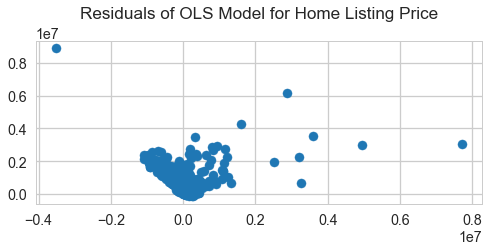

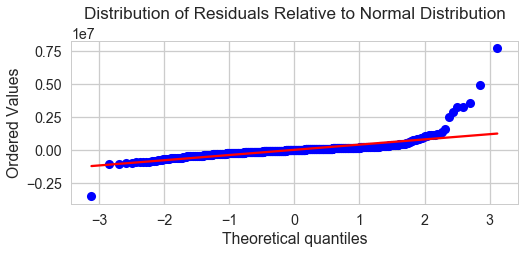

In [34]:
# calculate model residuals

import scipy as sp

pred_val = price_region_best.fittedvalues.copy()
true_val = active_listings_filtered['price'].values.copy()
residual = true_val - pred_val

# regression diagnostic plots; plotting model residuals
fig, ax = plt.subplots(figsize=(8,3))
ax.scatter(residual, pred_val)
plt.title('Residuals of OLS Model for Home Listing Price', y=1.1)
plt.show()


# regression diagnostic plots; plotting probability of residual data against the theoretical quantiles for 
# normal distribution; some deviations from normality but somewhat okay
fig, ax = plt.subplots(figsize=(8,3))
sp.stats.probplot(residual, plot=ax, fit=True)
plt.title('Distribution of Residuals Relative to Normal Distribution', y=1.1)
plt.show()

As with the original 'simple' linear regression model, these diagnostic plots indicate deviations from the normal distribution. With out knowledge of further parameters that dictate listing price (like finish quality, school district, and home age), adding region information to the linear regression model doesn't provide much benefit over a simple model based only on size, bedrooms, and bathrooms.

Real estate pricing is complex, but even imperfect models can yield important insights into the data. All other variables being equal, the listed price of a home in the Central neighborhood is boosted (by \$180,100) and depressed by being in the North_West or South neighborhoods (by -\$180,700 and -\$83,010, respectively). The inaccuracy of the estimates for the East region (-\$82,220) highlights that a linear regression model isn't sufficient to predict price with this given data set. Below, I used the final model to calculate some expected home prices and compare the values to the actual data.

In [37]:
# calculating predictions and actual values

# calculate predicted prices from model
small_central_pred = -1.658e+05 + (1.801e+05)*1 + 272.1343*1000
large_central_pred = -1.658e+05 + (1.801e+05)*1 + 272.1343*2500
large_nw_pred = -1.658e+05 + (-1.807e+05)*1 + 272.1343*2500

#
small_central_act = active_listings_filtered[(active_listings_filtered['region']=='Central') & 
                         (active_listings_filtered['sqft']<=1000)]['price'].mean()

large_central_act = active_listings_filtered[(active_listings_filtered['region']=='Central') & 
                         (active_listings_filtered['sqft']>=2500)]['price'].mean()

large_nw_act = active_listings_filtered[(active_listings_filtered['region']=='North_West') & 
                         (active_listings_filtered['sqft']>=2500)]['price'].mean()

print('The predicted price per sqft for a small central home is ${0:.2f} and the actual price per sqft is ${1:.2f}'.
      format(small_central_pred, small_central_act))

print('The predicted price per sqft for a large central home is ${0:.2f} and the actual price per sqft is ${1:.2f}'.
      format(large_central_pred, large_central_act))

print('The predicted price per sqft for a large north western home is ${0:.2f} and the actual price per sqft is ${1:.2f}'.
      format(large_nw_pred, large_nw_act))

The predicted price per sqft for a small central home is $286434.30 and the actual price per sqft is $243345.43
The predicted price per sqft for a large central home is $694635.75 and the actual price per sqft is $1581119.40
The predicted price per sqft for a large north western home is $333835.75 and the actual price per sqft is $444221.73


## Summary

* Are the regional differences in price and size statistically significant?
    
    **Yes, the distinctions are significant and indicate distinct home 'types' in different geographic regions.**
    
    
* Are comparable size listings in different regions significantly different in listing price? 
    
    **Yes, size-comparable listings in different regions are listed at significantly different prices.** 


* Can we model home pricing based on size and geography characteristics?
    
    **Kind of... a linear regression model using size and geography variables isn't a great fit for the data, but it does provide some meaningful insights.**

## Limitations and Further Exploration

There are many limitations in the modeling portion of this exploration. The only model considered was a linear regression model, and it may be the case that a linear model simply doesn't describe real estate pricing well. Many difficult-to-quantify home features (like style and finish quality) affect home price, and the present data set does not reflect these metrics. The regression diagnostic plots reveal a non-normal distribution in the data, and other models types may provide better estimates of price. Additionally, these diagnostic plots reveal a number of outliers that were not explored in depth. Addressing these outliers may yield more robust linear models.